In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import scipy.integrate as si
import scipy.optimize as so
import scipy.linalg as sl

import time

from numba import njit
from tqdm import trange

#from products import *

In [2]:
import numpy as np 
#from gauss_hf import *
# datafile = log_data(logfile='./logfiles/casscf24_s15_heh+_6-31g.log')
# dipmat_x = datafile.get_dipole_x_AO()
# dipmat_y = datafile.get_dipole_y_AO()
# dipmat_z = datafile.get_dipole_z_AO()
# S = datafile.get_overlap_AO()
P = np.load('casscf24_s15_heh+_6-31g_tensor.npz')

In [3]:
P.shape

(16, 16, 4, 4)

In [4]:
dimat=np.load('casscf24_s15_heh+_6-31g_CI_dimat.npz')

In [5]:
dimat.shape

(16, 16)

In [6]:
trajectory_number = 135
mol = 'heh+'
method = 'tdcasscf'
prefix = './dt0.008268/'
#prefix = '../mlhamdata/data_tdcasscf/'
trajnum = trajectory_number
traj = str(trajnum).zfill(3)
fname = prefix + 'time_coeffs.' + method + '_' + mol + '_sto-3g_' + traj + '_dt=0.008268au.txt'
tdcicoeffs = np.loadtxt(fname,dtype=np.complex128)

In [7]:
ham = np.load('casscf24_s15_heh+_6-31g_hamiltonian.npz')

In [8]:
ham = ham - np.diag([np.min(ham)]*ham.shape[0])

In [9]:
ham.shape

(16, 16)

In [10]:
#dimat = np.load('casscf22_s2_heh+_sto-3g_dipmat.npz')
runfile = np.load(prefix+'tdcasscf_heh+_sto-3g_'+str(trajnum).zfill(3)+'_dt=0.008268au.npz')
mydt = runfile['dt_au'].item()
print(mydt)

0.008268


In [11]:
offset = 0
tvec = np.arange(offset,offset+tdcicoeffs.shape[0])*runfile['dt_au']
tmeoff = runfile['ncyc']*2*np.pi/runfile['freq']
ef = (tvec>=0)*(tvec<=tmeoff)*(runfile['emax'])*np.sin(runfile['freq']*tvec)

In [12]:
#shape = 4
shape = 16
hamCI = np.expand_dims(ham,0) - np.einsum('i,jk->ijk',ef,dimat)
hamCI = (1+0j)*hamCI
numhamCI = hamCI.shape[0]
alldd = np.zeros((numhamCI,shape),dtype=np.float64)
allvv = np.zeros((numhamCI,shape,shape),dtype=np.complex128)
for i in range(numhamCI):
    dd, vv = np.linalg.eigh(hamCI[i,:,:])
    alldd[i,:] = dd
    allvv[i,:,:] = vv

In [13]:
newtdcicoeffs = np.zeros((tdcicoeffs.shape[0],shape),dtype=np.complex128)
newtdcicoeffs[0,0] = 1.0 
for i in range(newtdcicoeffs.shape[0]-1):
    newtdcicoeffs[i+1,:] = sl.expm(-1j*(ham-ef[i]*dimat)*runfile['dt_au']) @ newtdcicoeffs[i,:]

#print( np.mean(np.abs(newtdcicoeffs - tdcicoeffs[:,1:])) )

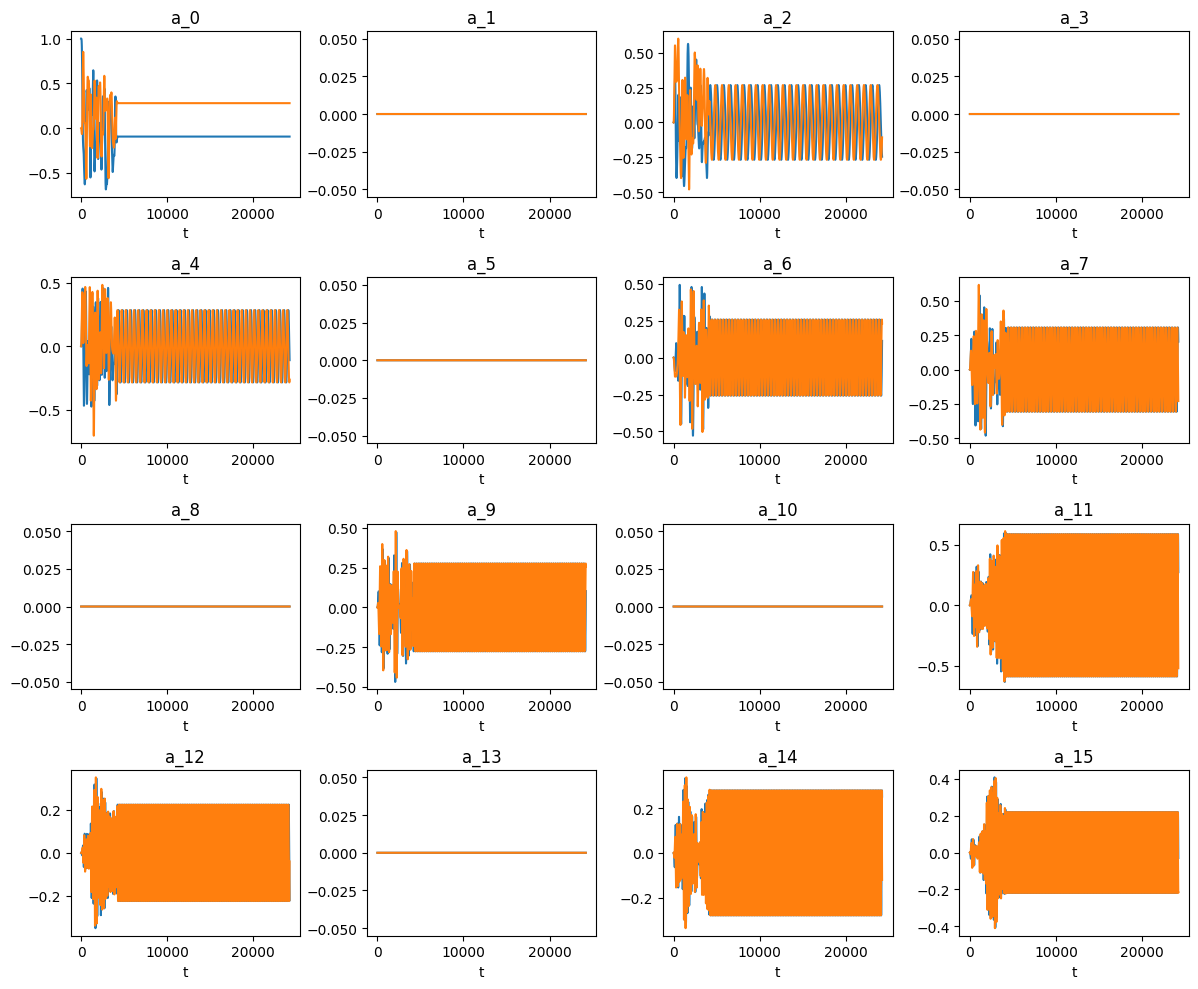

In [14]:
titles = ['a_'+str(i) for i in range(16)]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(12, 10))

# Loop through subplots and plot data
for i, ax in enumerate(axs.flat):
    ax.plot(newtdcicoeffs[:,i].real)
    ax.plot(newtdcicoeffs[:,i].imag)
    ax.set_xlabel('t')
    ax.set_title(titles[i])

# Adjust layout to prevent overlap of titles
plt.tight_layout()
#keep 0,2,4,6,7,9,11,12,14,15
# Show the plot
#plt.savefig('./newfigures/tdci_coeffs_computed_dimat.pdf')
plt.show()


In [15]:
bigtens = 2*P

In [16]:
S = np.array([[1.0,0.658292,0.300303,0.536094],[0.658292, 1.0,0.334248,0.746564], [ 0.300303,0.334248,1.0,0.634148 ],[0.536094,0.746564,0.634148,1.0]])
S == S.T

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [17]:
newrdmAO_p = np.einsum('ni,nj,ijab->nab',newtdcicoeffs,np.conjugate(newtdcicoeffs),bigtens)

In [18]:
traces_p = np.einsum('ijj->i', newrdmAO_p@S)

In [19]:
newrdmAO_p.shape, S.shape, newtdcicoeffs.shape

((24218, 4, 4), (4, 4), (24218, 16))

Text(0.5, 1.0, 'Trace with computed tensor')

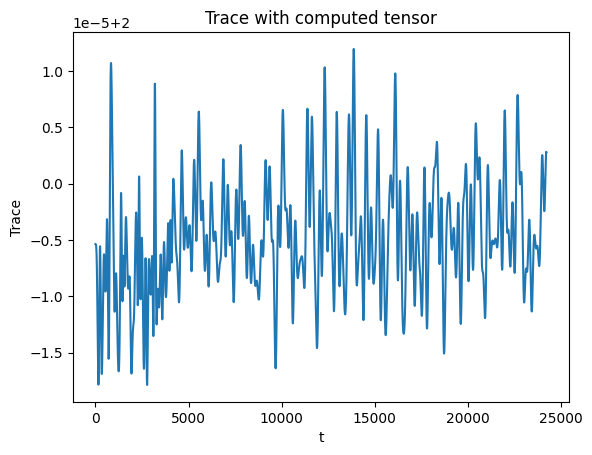

In [20]:
plt.plot(traces_p.real)
plt.xlabel('t')
plt.ylabel('Trace')
plt.title('Trace with computed tensor')
#plt.savefig('./newfigures/products_tensor_trace_dimat_computed.pdf')

In [21]:
newrdmAO = np.einsum('ni,nj,ijab->nab',newtdcicoeffs,np.conjugate(newtdcicoeffs),bigtens)

In [22]:
tdciden = np.einsum('ni,nj->nij',newtdcicoeffs,np.conj(newtdcicoeffs))

In [23]:
print( np.linalg.norm(np.einsum('nij,njk->nik',tdciden,tdciden) - tdciden) )

4.683904094926096e-11


In [24]:
bigtens.shape

(16, 16, 4, 4)

In [25]:
bigtens = bigtens.reshape((16**2,4**2)).astype(np.complex128)
matmulrdmAO = np.einsum('ij,jk->ik',np.transpose(tdciden,axes=[0,1,2]).reshape((-1,16*16)), bigtens).reshape((-1,4,4))

In [26]:
np.mean(np.abs(matmulrdmAO - newrdmAO))

0.0

In [27]:
ells = [240]

In [28]:
dd, vv = np.linalg.eigh(hamCI[10,:,:])
np.linalg.norm(vv @ np.diag(np.exp(-1j*mydt*dd)) @ vv.conj().T - sl.expm(-1j*hamCI[10,:,:]*mydt))

4.2112343316046855e-15

In [29]:
# matrix to convert an (nxn) Hermitian matrix to its vectorized form
drcCI = newtdcicoeffs.shape[1]
drc = 4
def mat2vec(n):
    # real part
    realmat = np.zeros((n**2,(n+1)*n//2),dtype=np.int16)
    for i in range(n):
        for j in range(n):
            row = i*n + j
            if i<=j:
                col = i*n + j - i*(i+1)//2
            else:
                col = j*n + i - j*(j+1)//2
            realmat[row,col]=1
    j = 0
    i = 0
    while j < (realmat.shape[1] - 1):
        realmat[-1,j] = -1
        j += n - i*1
        i += 1
    #
    # imaginary part
    imagmat = np.zeros((n**2,(n-1)*n//2),dtype=np.int16)
    for i in range(n):
        for j in range(n):
            row = i*n + j
            if i<j:
                col = i*n + j - (i+1)*(i+2)//2
                imagmat[row,col]=1
            if i>j:
                col = j*n + i - (j+1)*(j+2)//2
                imagmat[row,col]=-1
    symmat = np.hstack([realmat, 1j*imagmat])
    return symmat

smat = mat2vec(drcCI)
smatTrunc = np.delete(smat,(drcCI*(drcCI+1)//2 - 1),1)

In [30]:
def ind_to_pair_upper(n, i, j):
    if i < j:
        return i * (2 * n - i - 1) // 2 + j
    else:
        return j * (2 * n - j - 1) // 2 + i
n = drcCI 
upper_mapping = {}
#this is the diag upper representation
for i in range(n):
    for j in range(i, n):
        k = ind_to_pair_upper(n, i, j)
        #print(f"({i},{j}) -> {k}")
        upper_mapping[(i,j)] = k

In [31]:
def ind_to_pair_upper(n, i, j):
    if i < j:
        return i * (2 * n - i - 1) // 2 + j
    # else:
    #     return j * (2 * n - j - 1) // 2 + i
n = drcCI 
upper_wo_diag_mapping = {}
#this is the offdiag upper representation
k=136
for i in range(n):
    for j in range(i+1, n):
        #k = ind_to_pair_upper(n, i, j)
        #print(f"({i},{j}) -> {k}")
        upper_wo_diag_mapping[(i,j)] = k
        k+=1

In [32]:
# def ind_to_pair_lower(n, i, j):
#     if i > j:
#         return i * (i - 1) // 2 + j
# lower_mapping = {}
# for i in range(1, n):
#     for j in range(i):
#         k = ind_to_pair_lower(n, i, j)
#         print(f"({i},{j}) -> {k+136}")
#         lower_mapping[(i,j)] = k + 136

In [33]:
good_cols = np.array([ 0,  2,  4,  6,  7,  9, 11, 12, 14, 15])
zero_cols = np.array([ 1,  3,  5,  8,  10,  13])
bad_inds = []
del_upper = 0
for key in list(upper_mapping.keys()):
    for c in zero_cols:
        if c in key:
            #print(key, ' bad')
            bad_inds.append(upper_mapping[key])
            del_upper+=1
            break
print(del_upper)

81


In [34]:
del_lower = 0
for key in list(upper_wo_diag_mapping.keys()):
    for c in zero_cols:
        if c in key:
            #print(key, ' bad')
            bad_inds.append(upper_wo_diag_mapping[key])
            del_lower+=1
            break
print(del_lower)

75


In [35]:
# bad_inds

In [36]:
256 - (del_upper+del_lower)

100

In [37]:
split = 136-del_upper

In [38]:
good_inds = np.delete(np.arange(0,drcCI**2),bad_inds)
total_inds = good_inds.tolist()
total_inds.extend(bad_inds)
total_inds.sort()

In [39]:
all(total_inds == np.arange(0,drcCI**2))

True

In [40]:
#stick to just upper triangular representation
good_inds

array([  0,   2,   4,   6,   7,   9,  11,  12,  14,  15,  31,  33,  35,
        36,  38,  40,  41,  43,  44,  58,  60,  61,  63,  65,  66,  68,
        69,  81,  82,  84,  86,  87,  89,  90,  91,  93,  95,  96,  98,
        99, 108, 110, 111, 113, 114, 121, 122, 124, 125, 126, 128, 129,
       133, 134, 135, 137, 139, 141, 142, 144, 146, 147, 149, 150, 166,
       168, 169, 171, 173, 174, 176, 177, 191, 192, 194, 196, 197, 199,
       200, 211, 213, 215, 216, 218, 219, 221, 223, 224, 226, 227, 236,
       237, 239, 240, 246, 248, 249, 251, 252, 255])

In [41]:
A = np.random.normal(size=100)

In [42]:
recon = (smat[:,good_inds] @ A).reshape((16,16))
#recon[:]

In [43]:
#test 0 rows and columns
print([np.linalg.norm(recon[:,i]) for i in zero_cols])
print([np.linalg.norm(recon[i,:]) for i in zero_cols])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [44]:
future = 100
#@njit
def myprop(myrdmAO, ell):
    for j in range(ell,ell+future):
        # if j % 100 == 0:
        #     print(j)
        propagators = []
        Zjmis = []
        for i in range(1,ell+1):
            #dd, vv = np.linalg.eigh(hamCI[j-i,:,:])
            dd = alldd[j-i,:]
            vv = allvv[j-i,:,:]
            vv = (1+0j)*vv
            diagpiece = np.diag(np.exp(-1j*mydt*dd))
            myexp = vv @ diagpiece @ vv.conj().T
            propagators.append( myexp )
            # propagators.append( sl.expm(-1j*hamCI[j-i,:,:]*mydt) )
            Cmat = np.eye(drcCI,dtype=np.complex128)
            for k in range(i):
                Cmat = Cmat @ propagators[k]
            Amat = Cmat.conj().T
            Zjmi = np.kron( Cmat.T, Amat )
            Zjmis.append(Zjmi)

        # bigmatlist = [bigtens.reshape((16,4))]
        bigmat = np.zeros((drcCI**2,(drc**2)*(ell+1)), dtype=np.complex128)
        bigmat[:,:drc**2] = bigtens
        for i in range(ell):
            bigmat[:,(i+1)*(drc**2):(i+2)*(drc**2)] = Zjmis[i].T @ bigtens
            
        btrue = np.zeros((drc**2)*(ell+1), dtype=np.complex128)
        for i in range(ell+1):
            btrue[i*(drc**2):(i+1)*(drc**2)] = myrdmAO[j-i,:]


        # btrue = np.hstack(btruelist)
        # print(np.mean(np.abs(btrue.reshape((-1)) - newbtrue)))


        midmat = bigmat
        vmat = midmat.T

        # take into account Hermitian symmetry and constant trace property
        midmat2 = np.zeros((vmat.shape[0],  (drcCI**2-1)), dtype=np.complex128)
        midmat2 = vmat@smat[:,good_inds[good_inds!=135]]

        
        # monitor singular values
        _, ss, _ = np.linalg.svd(midmat2) # , compute_uv=False)
        if np.min(ss) < 1e-15:
            print("Warning: singular value < 1e-15 detected at time step " + str(j))

       # reconstruct full TDCI density
        xxapprox = np.real(np.linalg.pinv(midmat2) @ (btrue - vmat[:,-1]))
        xxapprox2 = np.zeros((xxapprox.shape[0]+1), dtype=np.complex128)
        xxapprox2[:split-1] = xxapprox[:split-1]
        xxapprox2[split-1] = 1.0
        xxapprox2[split:] = xxapprox[split-1:]
        
        
#         xxapprox2[:(drcCI+1)*drcCI//2 - 1] = xxapprox[:(drcCI+1)*drcCI//2 - 1]
#         xxapprox2[(drcCI+1)*drcCI//2 - 1] = 1.0
#         xxapprox2[(drcCI+1)*drcCI//2:] = xxapprox[(drcCI+1)*drcCI//2 - 1:]
        # xxapprox2 = np.insert(xxapprox,int((drcCI+1)*drcCI//2 - 1),1.0,0)
        #recon = (smat @ xxapprox2).reshape((drcCI,drcCI)).conj()
        recon = (smat[:,good_inds[:]] @ xxapprox2).reshape((drcCI,drcCI)).conj()
        assert (recon == recon.conjugate().transpose()).all()
        # propagate in full TDCI density space via one step of MMUT!
        dd = alldd[j,:]
        vv = allvv[j,:,:]
        myexpminus = vv @ np.diag(np.exp(-1j*mydt*dd)) @ vv.conj().T    
        myexpplus = vv @ np.diag(np.exp(1j*mydt*dd)) @ vv.conj().T    
        reconprop = myexpminus @ recon @ myexpplus

        # compute new rdm
        myrdmAO[j+1,:] = reconprop.reshape((-1)) @ bigtens
    return myrdmAO

In [45]:
MSEs00 = []
MSEs01 = []
MSEs11 = []
myrdmAOs = [] 
for ell in ells:
    numsteps = matmulrdmAO.shape[0]-1
    myrdmAO = np.zeros((numsteps, drc**2), dtype=np.complex128)
    myrdmAO[:ell+1,:] = newrdmAO[:ell+1,:,:].reshape((-1,drc**2))
    myrdmAO = myprop(myrdmAO, ell)
    traces = np.einsum('ijj ->i',myrdmAO[:ell+future].reshape((ell+future,4,4))@S)
    print(np.max(traces),np.min(traces))
    myrdmAOs.append(myrdmAO)
    print('done: '+str(ell)+' steps memory')
    MSEs00.append(np.mean((np.real(newrdmAO[:ell+future,0,0]) - np.real(myrdmAO[:ell+future,0]))**2))
    MSEs01.append(np.mean((np.real(newrdmAO[:ell+future,0,1]) -np.real(myrdmAO[:ell+future,1] ))**2))
    MSEs11.append(np.mean((np.real(newrdmAO[:ell+future,1,1]) - np.real(myrdmAO[:ell+future,3]))**2))

(1.999994637656644+0j) (1.9999442968803232+1.8013368574543165e-14j)
done: 240 steps memory


In [46]:
traces = np.einsum('ijj ->i',myrdmAO[:ell+future].reshape((ell+future,4,4))@S)

Text(0.5, 1.0, 'Trace after memory model propagation')

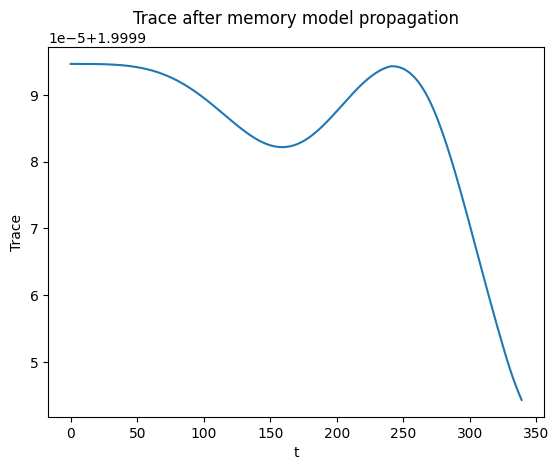

In [47]:
plt.plot(traces.real[:])
plt.xlabel('t')
plt.ylabel('Trace')
plt.title('Trace after memory model propagation')
#plt.savefig('./trace_post_prop.pdf')

In [48]:
myrdmAOs = np.array(myrdmAOs)
print(MSEs00)

[0.03758801982548335]


In [49]:
# plt.plot((np.real(newrdmAO[:ell+future,0,0])),color='black',label='True dynamics')
# plt.plot(np.real(myrdmAO[:ell+future,0]),color='red',label='Learned dynamics')
# plt.legend()
# plt.show()
# plt.close()

Text(0.5, 0, 't')

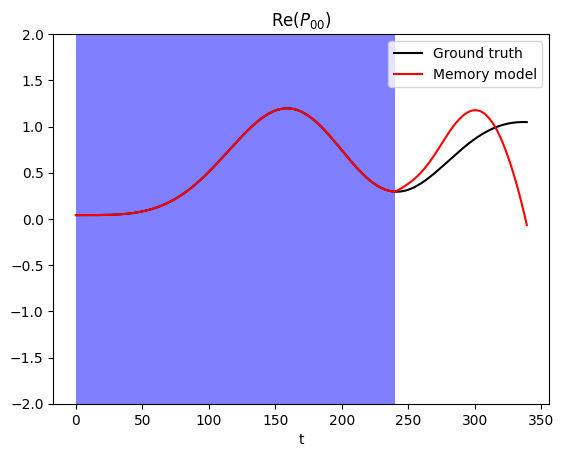

In [50]:
plt.plot((np.real(newrdmAO[:ell+future,0,0])),color='black')
plt.plot(np.real(myrdmAO[:ell+future,0]),color='red')
plt.legend(['Ground truth','Memory model'])
plt.axvspan(0, ells[0], color='blue', alpha=0.5, lw=0)
plt.ylim([-2,2]);
plt.title(r'Re$(P_{00})$')
plt.xlabel('t')
#plt.savefig('./post_prop_fit.pdf')

Text(0.5, 0, 't')

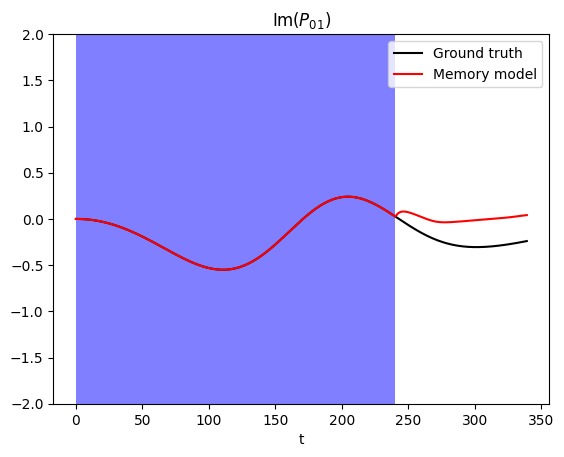

In [51]:
plt.plot((np.imag(newrdmAO[:ell+future,0,1])),color='black')
plt.plot(np.imag(myrdmAO[:ell+future,1]),color='red')
plt.legend(['Ground truth','Memory model'])
plt.axvspan(0, ells[0], color='blue', alpha=0.5, lw=0)
plt.ylim([-2,2]);
plt.title(r'Im$(P_{01})$')
plt.xlabel('t')
#plt.savefig('./post_prop_fit.pdf')